# 1. Introduction/Business Problem
Banglaore and Mumbai are the major employment centers in India. 

Weather, entertainment options, recreational activities offered by the city, access to healthcare all play a part in choosing one city over the other for relocation.

We will try and assess the poitive and neative points of both these cities in this project.

In [2]:
!conda install -c conda-forge folium --yes

Solving environment: ...working... done

# All requested packages already installed.



In [1]:
#Importing other dependencies

import folium # map rendering library

import numpy as np
import requests
import random
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe
import folium
from folium.plugins import MiniMap
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
# import k-means from clustering stage
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib_venn as mpv
print('Libraries imported.')

Libraries imported.


# 2. Data sourcing and wrangling

Pincode and geometrical coordinates are available on ttp://www.geonames.org/export/zip/. We download the file for India. The file is uploaded to labfolder for easy access.

In [2]:
#importing and examining the data:
import pandas as pd
import csv

import os
base_path = "D:\\Girish\\Coursera Files\\Capstone file" 
# defining path to import the file into Juptyter environment.File is downloaded from internet.

filename = "IN.txt"
path_to_file = os.path.join(base_path, filename)
fd = open(path_to_file , 'r')

crdntsdf=pd.read_csv(fd, sep='\s+', delimiter='\t', header=None)
crdntsdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,IN,744101,Marine Jetty,Andaman & Nicobar Islands,1,South Andaman,NaN,Portblair,NaN,11.6667,92.7500,3
1,IN,744101,Port Blair,Andaman & Nicobar Islands,1,South Andaman,NaN,Port Blair,NaN,11.6667,92.7500,4
2,IN,744101,N.S.Building,Andaman & Nicobar Islands,1,South Andaman,NaN,Portblair,NaN,11.6667,92.7500,3
3,IN,744102,Haddo,Andaman & Nicobar Islands,1,South Andaman,NaN,Port Blair,NaN,11.6833,92.7167,4
4,IN,744102,Chatham,Andaman & Nicobar Islands,1,South Andaman,NaN,Portblair,NaN,11.7000,92.6667,3


In [3]:
#dropping columns not required for our analysis
crdntsdf.drop(crdntsdf.columns[[0,4,6,8,11]], axis=1, inplace=True)

#Assigning column names for the revised df
crdntsdf = crdntsdf.rename(columns = {1:'Pincodes', 2:'Area', 3:'StateUT', 5:'Region',7:'City', 9:'Lat', 10:'Long' })

crdntsdf.head()

,Pincodes,Area,StateUT,Region,City,Lat,Long
0,744101,Marine Jetty,Andaman & Nicobar Islands,South Andaman,Portblair,11.6667,92.7500
1,744101,Port Blair,Andaman & Nicobar Islands,South Andaman,Port Blair,11.6667,92.7500
2,744101,N.S.Building,Andaman & Nicobar Islands,South Andaman,Portblair,11.6667,92.7500
3,744102,Haddo,Andaman & Nicobar Islands,South Andaman,Port Blair,11.6833,92.7167
4,744102,Chatham,Andaman & Nicobar Islands,South Andaman,Portblair,11.7000,92.6667


In [6]:
# Extracting data for Bangalore city from the master datafile
blrdata= crdntsdf[crdntsdf['City'].str.contains('Bangalore', na=False)]

In [7]:
blrdata.reset_index(drop=True)

,Pincodes,Area,StateUT,Region,City,Lat,Long
0,560001,Bangalore G.P.O.,Karnataka,Bangalore,Bangalore North,12.9914,77.5944
1,560001,Legislators Home,Karnataka,Bangalore,Bangalore North,12.9914,77.5944
2,560001,Mahatma Gandhi Road,Karnataka,Bangalore,Bangalore North,12.9914,77.5944
3,560001,Vidhana Soudha,Karnataka,Bangalore,Bangalore North,12.9914,77.5944
4,560001,Rajbhavan (Bangalore),Karnataka,Bangalore,Bangalore North,12.9914,77.5944
...,...,...,...,...,...,...,...
253,560110,Ullalu Upanagar,Karnataka,Bangalore,Bangalore,13.1791,77.0942
254,562130,Tavarekere (Bangalore),Karnataka,Bangalore,Bangaloresouth,13.9288,77.0614
255,562157,Bettahalsur,Karnataka,Bangalore,Bangalore North,13.1438,77.6169
256,562162,Madanayakanahalli,Karnataka,Bangalore,Bangalore North,17.8647,77.8229


In [8]:
# Extracting data for Mumbai city from the master datafile
Mbidata= crdntsdf[crdntsdf['City'].str.contains('Mumbai', na=False)]

In [9]:
Mbidata.reset_index(drop=True)

,Pincodes,Area,StateUT,Region,City,Lat,Long
0,400001,Mumbai G.P.O.,Maharashtra,Mumbai,Mumbai,18.6291,72.8919
1,400001,Bazargate,Maharashtra,Mumbai,Mumbai,18.6291,72.8919
2,400001,Town Hall (Mumbai),Maharashtra,Mumbai,Mumbai,18.6291,72.8919
3,400001,Tajmahal,Maharashtra,Mumbai,Mumbai,18.6291,72.8919
4,400001,Stock Exchange,Maharashtra,Mumbai,Mumbai,18.6291,72.8919
...,...,...,...,...,...,...,...
141,400098,Vidyanagari,Maharashtra,Mumbai,Mumbai,19.2355,72.8468
142,400099,Sahar P & T Colony,Maharashtra,Mumbai,Mumbai,19.2355,72.8468
143,400099,International Airport,Maharashtra,Mumbai,Mumbai,19.2355,72.8468
144,400099,Sahargaon,Maharashtra,Mumbai,Mumbai,19.2355,72.8468


Inspecting and cleaning the city data frames.

C:\Users\Tanay\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


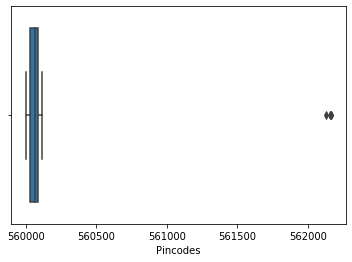

In [10]:
# cleaning dataset for Bangalore
import seaborn as sns
sns.boxplot(x=blrdata['Pincodes'])

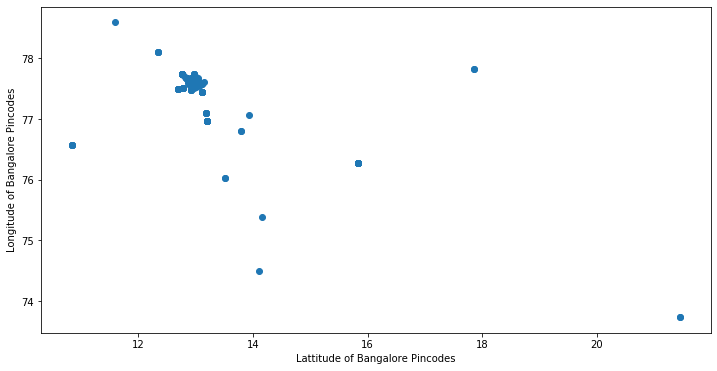

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(blrdata['Lat'], blrdata['Long'])
ax.set_xlabel('Lattitude of Bangalore Pincodes')
ax.set_ylabel('Longitude of Bangalore Pincodes')
plt.show()

Using the inter quartile range, we can identify the outliers and remove them from the dataframe

In [12]:
Q1 = blrdata.quantile(0.25)
Q3 = blrdata.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Pincodes    52.75000
Lat          0.10940
Long         0.06635
dtype: float64


In [13]:
Blr_out = blrdata[~((blrdata < (Q1 - 1.5 * IQR)) |(blrdata> (Q3 + 1.5 * IQR))).any(axis=1)]
Blr_out.shape

(182, 7)

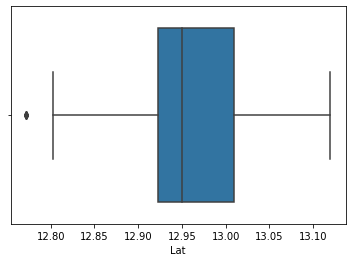

In [14]:
sns.boxplot(x=Blr_out['Lat'])

We can carryout similar operations for Mumbai dataframe.

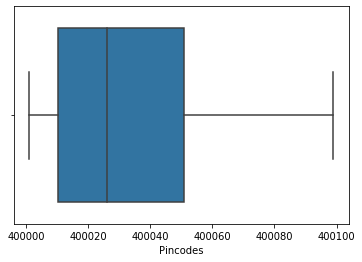

In [15]:
sns.boxplot(x=Mbidata['Pincodes'])

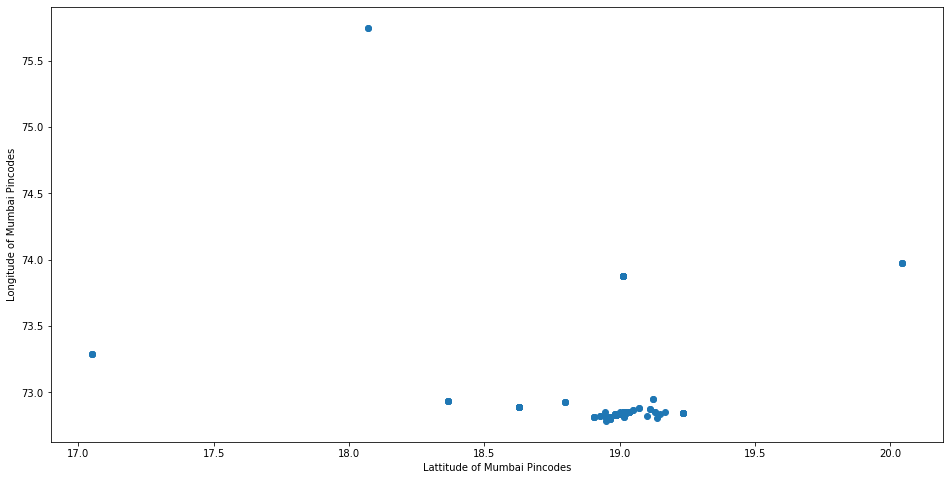

In [16]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(Mbidata['Lat'], Mbidata['Long'])
ax.set_xlabel('Lattitude of Mumbai Pincodes')
ax.set_ylabel('Longitude of Mumbai Pincodes')
plt.show()

In [17]:
Q1Mbi = Mbidata.quantile(0.25)
Q3Mbi = Mbidata.quantile(0.75)
IQRMbi = Q3Mbi - Q1Mbi
print(IQRMbi)

Pincodes    40.7500
Lat          0.0667
Long         0.0660
dtype: float64


In [18]:
Mbi_out = Mbidata[~((Mbidata < (Q1Mbi - 1.5 * IQRMbi)) |(Mbidata> (Q3Mbi + 1.5 * IQRMbi))).any(axis=1)]
Mbi_out.shape

(88, 7)

In [19]:
address = 'Bangalore, IN'

geolocator = Nominatim(user_agent="giri")
location = geolocator.geocode(address)
Blr_latitude = location.latitude
Blr_longitude = location.longitude
print('The geograpical coordinate of Bangalore is {}, {}.'.format(Blr_latitude, Blr_longitude))

address1 = 'Mumbai, IN'

location = geolocator.geocode(address1)
Mbi_latitude = location.latitude
Mbi_longitude = location.longitude
print('The geograpical coordinate of Mumbai is {}, {}.'.format(Mbi_latitude, Mbi_longitude))

centerLatitude = (Blr_latitude + Mbi_latitude)/2
centerLongitude = (Blr_longitude + Mbi_longitude)/2

print('\nThe geograpical central coordinates are {}, {}.'.format(centerLatitude, centerLongitude))

The geograpical coordinate of Bangalore is 12.9791198, 77.5912997.
The geograpical coordinate of Mumbai is 18.9387711, 72.8353355.

The geograpical central coordinates are 15.95894545, 75.2133176.


Append Bangalore and Mumbai tables

In [20]:
df = Blr_out.append(Mbi_out, True).reset_index(drop = True)

df.head()

,Pincodes,Area,StateUT,Region,City,Lat,Long
0,560001,Bangalore G.P.O.,Karnataka,Bangalore,Bangalore North,12.9914,77.5944
1,560001,Legislators Home,Karnataka,Bangalore,Bangalore North,12.9914,77.5944
2,560001,Mahatma Gandhi Road,Karnataka,Bangalore,Bangalore North,12.9914,77.5944
3,560001,Vidhana Soudha,Karnataka,Bangalore,Bangalore North,12.9914,77.5944
4,560001,Rajbhavan (Bangalore),Karnataka,Bangalore,Bangalore North,12.9914,77.5944


In [21]:
df.dtypes

Pincodes      int64
Area         object
StateUT      object
Region       object
City         object
Lat         float64
Long        float64
dtype: object

In [22]:
df.shape

(270, 7)

We can observe that total no of observations has come down to 270 rows. Lets plot the map.

Visualize neighborhoods of both cities in a map using Folium

In [23]:
map_giri = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lng, area, region in zip(df['Lat'], df['Long'], df['Area'], df['Region']):
    label = '{}, {}'.format(area, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_giri)
map_giri

Mapping pincodes of Bangalore City

In [24]:
map_giri = folium.Map(location=[Blr_latitude, Blr_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, area, region in zip(df['Lat'], df['Long'], df['Area'], df['Region']):
    label = '{}, {}'.format(area, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_giri)

minimap = MiniMap(position = 'bottomright', center_fixed = (Blr_latitude, Blr_longitude), zoom_level_fixed = 8)
minimap.add_to(map_giri)

minimap = MiniMap(position= 'topleft',  center_fixed = (Mbi_latitude, Mbi_longitude), zoom_level_fixed = 8)
minimap.add_to(map_giri)
map_giri

Mapping pincodes of City of Mumbai

In [25]:
map_giriMbi = folium.Map(location=[Mbi_latitude, Mbi_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, area, region in zip(df['Lat'], df['Long'], df['Area'], df['Region']):
    label = '{}, {}'.format(area, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_giriMbi)

minimap = MiniMap(position = 'bottomright', center_fixed = (Blr_latitude, Blr_longitude), zoom_level_fixed = 8)
minimap.add_to(map_giriMbi)

minimap = MiniMap(position= 'topleft',  center_fixed = (Mbi_latitude, Mbi_longitude), zoom_level_fixed = 8)
minimap.add_to(map_giriMbi)
map_giriMbi

Fetching venue details using google places API.

In [26]:
CLIENT_ID = 'RYH3PDGENWRZR2O4PSDJHAF1YG1GTSBHHOZUEWUCVCHQ4KAX' # your Foursquare ID
CLIENT_SECRET = '1UOPVAQ1VTKADDDI0OIVBUCFKFRJBCBCUGFCRCFPFZ5WPYUZ' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RYH3PDGENWRZR2O4PSDJHAF1YG1GTSBHHOZUEWUCVCHQ4KAX
CLIENT_SECRET:1UOPVAQ1VTKADDDI0OIVBUCFKFRJBCBCUGFCRCFPFZ5WPYUZ


In [27]:
# Defining function to fetch venue details from foursquare
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getVenues(names, Pincodes, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, Pincode, lat, lng in zip(names, Pincodes, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+name+color.END)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            Pincode,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Pincode',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues)

In [28]:
Blr_venues= getVenues(names=Blr_out['Area'],
                                   Pincodes = Blr_out['Pincodes'],
                                   latitudes=Blr_out['Lat'],
                                   longitudes=Blr_out['Long']
                                  )

1 | Bangalore G.P.O.
2 | Legislators Home
3 | Mahatma Gandhi Road
4 | Vidhana Soudha
5 | Rajbhavan (Bangalore)
6 | HighCourt
7 | Cubban Road
8 | Bangalore Bazaar
9 | CMM Court Complex
10 | Dr. Ambedkar Veedhi
11 | Bangalore City
12 | Bangalore Corporation Building
13 | Sri Jayachamarajendra Road
14 | Palace Guttahalli
15 | Malleswaram
16 | Swimming Pool Extn
17 | Vyalikaval Extn
18 | Basavanagudi
19 | Rajajinagar
20 | Industrial Estate (Bangalore)
21 | Rajajinagar IVth Block
22 | Jalahalli
23 | Seshadripuram
24 | Gayathrinagar
25 | Srirampuram
26 | Magadi Road
27 | Museum Road
28 | Richmond Town
29 | CMP Centre And School
30 | Sampangiramnagar
31 | Wilson Garden
32 | Shanthinagar
33 | Adugodi
34 | R T Nagar
35 | Kanakanagar
36 | P&T Col. Kavalbyrasandra
37 | Maruthi Sevanagar
38 | Agara
39 | Koramangala
40 | Koramangala I Block
41 | St. John's Medical College
42 | Carmelram
43 | Krishnarajapuram
44 | Devasandra
45 | Marathahalli Colony
46 | Doddanekkundi
47 | Yemalur
48 | Rameshnagar
4

In [35]:
# will save this dataframe into csv for future reference:
Blr_venues.to_csv(r'D:\Girish\Coursera Files\Capstone file\Blr_venues.csv')

In [60]:
Blr_venues=pd.read_csv('Blr_venues.csv')

In [61]:
Blr_venues.drop(Blr_venues.columns[[0]], axis=1, inplace=True)
Blr_venues.head()

,Neighborhood,Pincode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bangalore G.P.O.,560001,12.9914,77.5944,Millers 46,12.991666,77.594207,Steakhouse
1,Bangalore G.P.O.,560001,12.9914,77.5944,Ujwal Bar & Restaurant,12.992280,77.594473,Indian Restaurant
2,Bangalore G.P.O.,560001,12.9914,77.5944,Alliance Française,12.991232,77.596723,Concert Hall
3,Bangalore G.P.O.,560001,12.9914,77.5944,Imperial Restaurant,12.991150,77.593837,Indian Restaurant
4,Bangalore G.P.O.,560001,12.9914,77.5944,Infinitea,12.987157,77.594835,Tea Room


In [62]:
Blr_venues.shape

(3008, 8)

In [35]:
# Finding unique categories of venues in Bangalore
print('There are {} uniques categories.'.format(len(Blr_venues['Venue Category'].unique())))

There are 141 uniques categories.


In [36]:
#Let's check how many venues were returned for each neighborhood
Blr_venues.groupby('Neighborhood').count()

,Pincode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Adugodi,4,4,4,4,4,4,4
Agara,43,43,43,43,43,43,43
Amruthahalli,6,6,6,6,6,6,6
Arabic College,3,3,3,3,3,3,3
Ashoknagar (Bangalore),11,11,11,11,11,11,11
...,...,...,...,...,...,...,...
Wilson Garden,11,11,11,11,11,11,11
Wipro Limited,6,6,6,6,6,6,6
Yelachenahalli,2,2,2,2,2,2,2


In [37]:
# one hot encoding
Blr_onehot = pd.get_dummies(Blr_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Blr_onehot['Neighborhood'] = Blr_venues['Neighborhood'] 
Blr_onehot['Pincode'] = Blr_venues['Pincode']
Blr_onehot['Latitude'] = Blr_venues['Neighborhood Latitude']
Blr_onehot['Longitude'] = Blr_venues['Neighborhood Longitude']

# move neighborhood column to the first column
fixed_columns = [Blr_onehot.columns[-1]] + list(Blr_onehot.columns[:-1])
Blr_onehot = Blr_onehot[fixed_columns]

Blr_grouped = Blr_onehot.groupby(['Neighborhood','Pincode','Latitude','Longitude']).mean().reset_index()

#print(tony_venues.drop_duplicates(["Neighborhood"],inplace = False)['Neighborhood'].reset_index(drop=True))    
Blr_grouped

,Neighborhood,Pincode,Latitude,Longitude,ATM,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Thai Restaurant,Tibetan Restaurant,Toll Plaza,Track Stadium,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Women's Store,Yoga Studio,Zoo Exhibit
0,Adugodi,560030,12.9440,77.6079,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,Agara,560034,12.9320,77.6227,0.000000,0.023256,0.023256,0.0,0.0,0.023256,...,0.023256,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.023256,0.0
2,Amruthahalli,560092,13.0597,77.5831,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Arabic College,560045,13.0360,77.6226,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,Ashoknagar (Bangalore),560050,13.0323,77.5609,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Wilson Garden,560027,12.9506,77.5952,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
172,Wipro Limited,560100,12.8458,77.6727,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.166667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
173,Yelachenahalli,560078,12.9020,77.5709,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
174,Yelahanka,560064,13.1013,77.5963,0.333333,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0


In [38]:
#Printing each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in Blr_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Blr_grouped[Blr_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[4:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adugodi----
                  venue  freq
0         Design Studio  0.25
1     Indian Restaurant  0.25
2           Bus Station  0.25
3  Fast Food Restaurant  0.25
4                   ATM  0.00


----Agara----
               venue  freq
0               Café  0.21
1  Indian Restaurant  0.16
2        Coffee Shop  0.07
3                Pub  0.07
4             Lounge  0.05


----Amruthahalli----
                venue  freq
0  Italian Restaurant  0.17
1              Resort  0.17
2         Snack Place  0.17
3         Coffee Shop  0.17
4                Café  0.17


----Arabic College----
              venue  freq
0       Coffee Shop  0.33
1       Pizza Place  0.33
2       Bus Station  0.33
3               ATM  0.00
4  Parsi Restaurant  0.00


----Ashoknagar (Bangalore)----
               venue  freq
0        Bus Station  0.18
1  Indian Restaurant  0.18
2       Burger Joint  0.09
3       Dessert Shop  0.09
4              Diner  0.09


----B Sk II Stage----
                venue  freq
0      

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [39]:
# defining a function for sorting venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
#Now let's create the new dataframe and display the top 5 venues for each neighborhood.
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Blr_venues_sorted = pd.DataFrame(columns=columns)
Blr_venues_sorted['Neighborhood'] = Blr_grouped['Neighborhood']

for ind in np.arange(Blr_grouped.shape[0]):
       Blr_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Blr_grouped.iloc[ind, 4:], num_top_venues)

Blr_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adugodi,Indian Restaurant,Fast Food Restaurant,Design Studio,Bus Station,Zoo Exhibit
1,Agara,Café,Indian Restaurant,Coffee Shop,Pub,Lounge
2,Amruthahalli,Italian Restaurant,Coffee Shop,Snack Place,Resort,Café
3,Arabic College,Coffee Shop,Pizza Place,Bus Station,Zoo Exhibit,Donut Shop
4,Ashoknagar (Bangalore),Indian Restaurant,Bus Station,Gym,Ice Cream Shop,Burger Joint
...,...,...,...,...,...,...
171,Wilson Garden,Indian Restaurant,Southern / Soul Food Restaurant,Café,Hotel,Coffee Shop
172,Wipro Limited,Indian Restaurant,Outlet Store,Toll Plaza,Bus Station,Middle Eastern Restaurant
173,Yelachenahalli,Pizza Place,Zoo Exhibit,Dive Bar,Financial or Legal Service,Fast Food Restaurant
174,Yelahanka,Mobile Phone Shop,Train Station,Zoo Exhibit,Donut Shop,Financial or Legal Service


#Repeating similar operations for Mumbai

In [29]:
Mbi_venues= getVenues(names=Mbi_out['Area'],
                                   Pincodes = Mbi_out['Pincodes'],
                                   latitudes=Mbi_out['Lat'],
                                   longitudes=Mbi_out['Long']
                                  )

1 | Girgaon
2 | Opera House
3 | Ambewadi (Mumbai)
4 | Charni Road
5 | Chaupati
6 | Madhavbaug
7 | Colaba
8 | Holiday Camp
9 | V.W.T.C.
10 | Asvini
11 | Malabar Hill
12 | Tardeo
13 | Grant Road
14 | S V Marg
15 | N.S.Patkar Marg
16 | Bharat Nagar (Mumbai)
17 | Agripada
18 | Chinchpokli
19 | Jacob Circle
20 | Haines Road
21 | Parel
22 | Chamarbaug
23 | Haffkin Institute
24 | Lal Baug
25 | Parel Naka
26 | Delisle Road
27 | Naigaon (Mumbai)
28 | Dadar
29 | Dadar Colony
30 | Sewri
31 | Mahim
32 | Mahim Bazar
33 | Mori Road
34 | Kapad Bazar
35 | Mahim East
36 | Dharavi Road
37 | Dharavi
38 | Worli
39 | Worli Naka
40 | Matunga
41 | Marine Lines
42 | Churchgate
43 | Central Building
44 | Nariman Point
45 | New Yogakshema
46 | Sion
47 | Chunabhatti
48 | Nehru Nagar (Mumbai)
49 | Prabhadevi
50 | New Prabhadevi Road
51 | Cumballa Sea Face
52 | Gowalia Tank
53 | Dr Deshmukh Marg
54 | Cumballa Hill
55 | V J B Udyan
56 | Ranade Road
57 | Gokhale Road (Mumbai)
58 | Bhawani Shankar
59 | Bhawani Shanka

In [30]:
# will save this dataframe into csv for future reference:
Mbi_venues.to_csv(r'D:\Girish\Coursera Files\Capstone file\Mbi_venues.csv')

In [41]:
Mbi_venues=pd.read_csv('Mbi_venues.csv')

In [42]:
Mbi_venues.drop(Mbi_venues.columns[[0]], axis=1, inplace=True)
Mbi_venues.head()

,Neighborhood,Pincode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Girgaon,400004,18.95,72.8167,Palms - Catholic Gymkhana,18.949760,72.820019,Restaurant
1,Girgaon,400004,18.95,72.8167,Bachelors Juice House,18.950088,72.819185,Juice Bar
2,Girgaon,400004,18.95,72.8167,Bachelorr's Ice Creams,18.954113,72.815396,Ice Cream Shop
3,Girgaon,400004,18.95,72.8167,Mafatlal Hindu Bath & Boating Club,18.953616,72.815366,Harbor / Marina
4,Girgaon,400004,18.95,72.8167,Gola's,18.949307,72.819453,Food Truck


In [43]:
Mbi_venues.shape

(1177, 8)

In [44]:
# Finding unique categories of venues in Mumbai
print('There are {} uniques categories.'.format(len(Mbi_venues['Venue Category'].unique())))

There are 85 uniques categories.


In [45]:
#Let's check how many venues were returned for each neighborhood
Mbi_venues.groupby('Neighborhood').count()

,Pincode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
A I Staff Colony,8,8,8,8,8,8,8
Agripada,4,4,4,4,4,4,4
Ambewadi (Mumbai),20,20,20,20,20,20,20
Andheri East,8,8,8,8,8,8,8
Antop Hill,16,16,16,16,16,16,16
...,...,...,...,...,...,...,...
Worli,9,9,9,9,9,9,9
Worli Colony,16,16,16,16,16,16,16
Worli Naka,9,9,9,9,9,9,9


In [46]:
# one hot encoding
Mbi_onehot = pd.get_dummies(Mbi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Mbi_onehot['Neighborhood'] = Mbi_venues['Neighborhood'] 
Mbi_onehot['Pincode'] = Mbi_venues['Pincode']
Mbi_onehot['Latitude'] = Mbi_venues['Neighborhood Latitude']
Mbi_onehot['Longitude'] = Mbi_venues['Neighborhood Longitude']

# move neighborhood column to the first column
fixed_columns = [Mbi_onehot.columns[-1]] + list(Mbi_onehot.columns[:-1])
Mbi_onehot = Mbi_onehot[fixed_columns]

Mbi_grouped = Mbi_onehot.groupby(['Neighborhood','Pincode','Latitude','Longitude']).mean().reset_index()

#print(tony_venues.drop_duplicates(["Neighborhood"],inplace = False)['Neighborhood'].reset_index(drop=True))    
Mbi_grouped

,Neighborhood,Pincode,Latitude,Longitude,Aquarium,Asian Restaurant,Bakery,Bank,Bar,Beach,...,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Women's Store,Yoga Studio
0,A I Staff Colony,400029,18.9860,72.8259,0.00,0.125,0.00,0.0000,0.125,0.0,...,0.0,0.125,0.0,0.0,0.0,0.0,0.1250,0.0,0.0,0.0
1,Agripada,400011,18.9833,72.8333,0.00,0.000,0.00,0.0000,0.000,0.0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
2,Ambewadi (Mumbai),400004,18.9500,72.8167,0.05,0.000,0.05,0.0000,0.000,0.0,...,0.0,0.000,0.0,0.0,0.0,0.1,0.0000,0.0,0.0,0.0
3,Andheri East,400069,19.1145,72.8712,0.00,0.125,0.00,0.0000,0.000,0.0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.1250,0.0,0.0,0.0
4,Antop Hill,400037,19.0167,72.8500,0.00,0.000,0.00,0.0625,0.000,0.0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Worli,400018,19.0167,72.8167,0.00,0.000,0.00,0.0000,0.000,0.0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
82,Worli Colony,400030,19.0167,72.8500,0.00,0.000,0.00,0.0625,0.000,0.0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0
83,Worli Naka,400018,19.0167,72.8167,0.00,0.000,0.00,0.0000,0.000,0.0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
84,Worli Police Camp,400030,19.0167,72.8500,0.00,0.000,0.00,0.0625,0.000,0.0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0


In [47]:
#Printing each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in Mbi_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Mbi_grouped[Mbi_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[4:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----A I Staff Colony----
                           venue  freq
0     Modern European Restaurant  0.12
1                            Spa  0.12
2               Asian Restaurant  0.12
3                            Bar  0.12
4  Vegetarian / Vegan Restaurant  0.12


----Agripada----
                    venue  freq
0          History Museum  0.25
1    Fast Food Restaurant  0.25
2  Furniture / Home Store  0.25
3               Multiplex  0.25
4                Aquarium  0.00


----Ambewadi (Mumbai)----
               venue  freq
0  Indian Restaurant  0.10
1    Harbor / Marina  0.10
2      Train Station  0.10
3           Aquarium  0.05
4         Smoke Shop  0.05


----Andheri East----
               venue  freq
0              Hotel  0.25
1              Diner  0.25
2   Asian Restaurant  0.12
3  Indian Restaurant  0.12
4          Hotel Bar  0.12


----Antop Hill----
               venue  freq
0        Coffee Shop  0.19
1  Indian Restaurant  0.12
2        Bus Station  0.12
3               Café  0.12

In [48]:
#Now let's create the new dataframe and display the top 5 venues for each neighborhood.
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Mbi_venues_sorted = pd.DataFrame(columns=columns)
Mbi_venues_sorted['Neighborhood'] = Mbi_grouped['Neighborhood']

for ind in np.arange(Mbi_grouped.shape[0]):
      Mbi_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Mbi_grouped.iloc[ind, 4:], num_top_venues)

Mbi_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,A I Staff Colony,Asian Restaurant,Tea Room,Coffee Shop,Modern European Restaurant,Café
1,Agripada,Fast Food Restaurant,Furniture / Home Store,Multiplex,History Museum,Yoga Studio
2,Ambewadi (Mumbai),Harbor / Marina,Train Station,Indian Restaurant,Pizza Place,Smoke Shop
3,Andheri East,Hotel,Diner,Indian Restaurant,Hotel Bar,Asian Restaurant
4,Antop Hill,Coffee Shop,Bus Station,Indian Restaurant,Café,Farmers Market
...,...,...,...,...,...,...
81,Worli,Café,Gun Range,Garden,Nightclub,French Restaurant
82,Worli Colony,Coffee Shop,Bus Station,Indian Restaurant,Café,Farmers Market
83,Worli Naka,Café,Gun Range,Garden,Nightclub,French Restaurant
84,Worli Police Camp,Coffee Shop,Bus Station,Indian Restaurant,Café,Farmers Market


Common Venue categories

Let's find out how many venue categories are common in both cities data.
We'll deal with only common vanue categories data amd rest other venue categories will be dropped.

In [49]:
print('Leaving {} columns of Bangalore city data\nLeaving {} columns of Mumbai city data'
      .format(list(Blr_grouped.columns[0:4]), list(Mbi_grouped.columns[0:4])))
common = 0
diff_in_Blr = 0

for i in Blr_grouped.columns[4:]:
    if i in Mbi_grouped.columns[4:]:
        common += 1
    else:
        diff_in_Blr += 1

print('\nNumber of common venue categories in both data are       :{}\n\
Number of different venue categories in Bangalore city are: {}\n\
Number of different venue catehories in Mumbai city are : {}'.format(common, diff_in_Blr,
                                                                     len(Mbi_grouped.columns[4:])-common))

Leaving ['Neighborhood', 'Pincode', 'Latitude', 'Longitude'] columns of Bangalore city data
Leaving ['Neighborhood', 'Pincode', 'Latitude', 'Longitude'] columns of Mumbai city data

Number of common venue categories in both data are       :57
Number of different venue categories in Bangalore city are: 83
Number of different venue catehories in Mumbai city are : 28


In [51]:
from matplotlib_venn import venn2

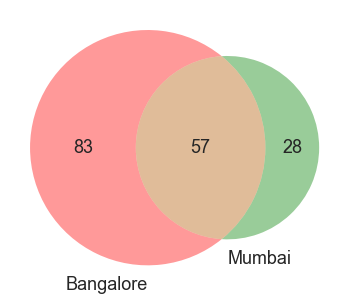

In [105]:
cl1 = set(Blr_grouped.columns[4:])
cl2 = set(Mbi_grouped.columns[4:])
plt.figure(figsize = (6,6))
out = venn2([set(cl1), set(cl2)], set_labels = ['Bangalore', 'Mumbai'])
# chnage the text size of matplotlib venn:https://stackoverflow.com/a/29426251
for text in out.set_labels:
    text.set_fontsize(18)
for text in out.subset_labels:
    text.set_fontsize(18)
plt.show()

Let's get only common venue categories of both data and drop the rest other categories.

In [114]:
comm_col = []
for i in Blr_grouped.columns[4:]:
    if i in Mbi_grouped.columns[4:]:
        comm_col.append(i)

col1 = list(Blr_grouped.columns[0:4]) + comm_col
col2 = list(Mbi_grouped.columns[0:4]) + comm_col
print('Before removing non-common shape of Bangalore: {}, and shape of Mumbai is: {}'
      .format(Blr_grouped.shape,Mbi_grouped.shape))
Blr_grouped1 = Blr_grouped.loc[:, col1]
Mbi_grouped2 = Mbi_grouped.loc[:, col2]
print('After removing non-common shape of Bangalore: {}, and shape of Mumbai is: {}'
      .format(Blr_grouped1.shape, Mbi_grouped2.shape))

Before removing non-common shape of Bangalore: (176, 144), and shape of Mumbai is: (86, 89)
After removing non-common shape of Bangalore: (176, 61), and shape of Mumbai is: (86, 61)


#Combining the dataframes of both cities

In [120]:
giri_grouped=pd.concat([Blr_grouped, Mbi_grouped])
giri_grouped=giri_grouped.reset_index(drop=True)

giri_grouped

,Neighborhood,Pincode,Latitude,Longitude,ATM,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Other Great Outdoors,Performing Arts Venue,Plaza,Recreation Center,Scenic Lookout,Spanish Restaurant,Sports Club,Tennis Court,Theater,Wine Bar
0,Adugodi,560030,12.9440,77.6079,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Agara,560034,12.9320,77.6227,0.0,0.023256,0.023256,0.0,0.0,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amruthahalli,560092,13.0597,77.5831,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arabic College,560045,13.0360,77.6226,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ashoknagar (Bangalore),560050,13.0323,77.5609,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Worli,400018,19.0167,72.8167,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0
258,Worli Colony,400030,19.0167,72.8500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
259,Worli Naka,400018,19.0167,72.8167,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0
260,Worli Police Camp,400030,19.0167,72.8500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [122]:
giri_grouped=giri_grouped.replace(np.nan,0)

In [112]:
giri_grouped.dtypes

Neighborhood           object
Pincode                 int64
Latitude              float64
Longitude             float64
ATM                   float64
                       ...   
Spanish Restaurant    float64
Sports Club           float64
Tennis Court          float64
Theater               float64
Wine Bar              float64
Length: 172, dtype: object

Find centroids with K-means

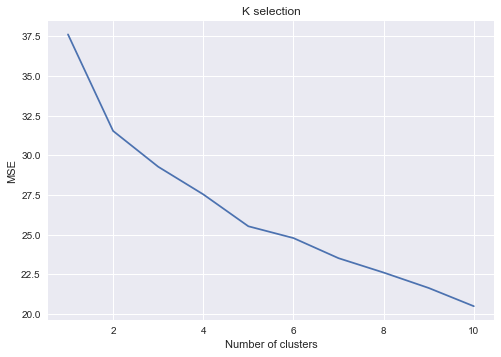

In [168]:
# Finding best k
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
giri_grouped_clustering = giri_grouped.drop(['Neighborhood','Pincode','Latitude','Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(giri_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

Clustering

As per the elbow, 5 clusters should be enough. We will maintain 5 clusters

In [171]:
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(giri_grouped_clustering)
    
giri_merged = giri_grouped

# add clustering labels
giri_merged['Cluster Labels'] = kmeans.labels_

giri_merged

,Neighborhood,Pincode,Latitude,Longitude,ATM,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Performing Arts Venue,Plaza,Recreation Center,Scenic Lookout,Spanish Restaurant,Sports Club,Tennis Court,Theater,Wine Bar,Cluster Labels
0,Adugodi,560030,12.9440,77.6079,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,4
1,Agara,560034,12.9320,77.6227,0.0,0.023256,0.023256,0.0,0.0,0.023256,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,4
2,Amruthahalli,560092,13.0597,77.5831,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1
3,Arabic College,560045,13.0360,77.6226,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0
4,Ashoknagar (Bangalore),560050,13.0323,77.5609,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Worli,400018,19.0167,72.8167,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,1
258,Worli Colony,400030,19.0167,72.8500,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0
259,Worli Naka,400018,19.0167,72.8167,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,1
260,Worli Police Camp,400030,19.0167,72.8500,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0


Displaying clusters in a map

In [172]:
map_clusters = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(giri_merged['Latitude'], giri_merged['Longitude'], 
                                  giri_merged['Neighborhood'], giri_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [153]:
# create map for Bangalore
map_clusters = folium.Map(location=[Blr_latitude, Blr_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(giri_grouped['Latitude'], giri_grouped['Longitude'], 
                                  giri_grouped['Neighborhood'],giri_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
minimap = MiniMap(position = 'topleft', center_fixed = (Blr_latitude, Blr_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (Mbi_latitude, Mbi_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [173]:
# create map for Mumbai
map_clusters = folium.Map(location=[Mbi_latitude, Mbi_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(giri_grouped['Latitude'], giri_grouped['Longitude'], 
                                  giri_grouped['Neighborhood'],giri_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
minimap = MiniMap(position = 'topleft', center_fixed = (Mbi_latitude, Mbi_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (Blr_latitude, Blr_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [177]:
cl1 = giri_merged.loc[giri_merged['Cluster Labels'] == 0, giri_merged.columns[[0] + list(range(5, giri_merged.shape[1]))]]
cl1


,Neighborhood,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Performing Arts Venue,Plaza,Recreation Center,Scenic Lookout,Spanish Restaurant,Sports Club,Tennis Court,Theater,Wine Bar,Cluster Labels
3,Arabic College,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,Ashoknagar (Bangalore),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,Banashankari,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
23,Bnagalore Viswavidalaya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
26,Bommasandra Industrial Estate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
35,Chickpet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
41,Dasarahalli(Srinagar),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
53,H.K.P. Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
54,Hebbagodi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
97,Laggere,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [178]:
cl2 = giri_merged.loc[giri_merged['Cluster Labels'] == 1, giri_merged.columns[[0] + list(range(5, giri_merged.shape[1]))]]
cl2

,Neighborhood,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Performing Arts Venue,Plaza,Recreation Center,Scenic Lookout,Spanish Restaurant,Sports Club,Tennis Court,Theater,Wine Bar,Cluster Labels
2,Amruthahalli,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1
11,Bangalore City,0.0,0.0,0.0,0.02,0.02,0.02,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1
12,Bangalore Corporation Building,0.0,0.0,0.0,0.02,0.02,0.02,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1
19,Begur,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1
21,Benson Town,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,Sion,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.1,0.0,0.0,1
251,Tardeo,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1
254,V.W.T.C.,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1
257,Worli,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,1


In [179]:
cl3 = giri_merged.loc[giri_merged['Cluster Labels'] == 2, giri_merged.columns[[0] + list(range(5, giri_merged.shape[1]))]]
cl3

,Neighborhood,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Performing Arts Venue,Plaza,Recreation Center,Scenic Lookout,Spanish Restaurant,Sports Club,Tennis Court,Theater,Wine Bar,Cluster Labels
24,Bolare,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
77,Kagalipura,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
150,Somanhalli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
159,Taralu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
160,Thattekuppe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
163,Udaypura,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [180]:
cl4 = giri_merged.loc[giri_merged['Cluster Labels'] == 3, giri_merged.columns[[0] + list(range(5, giri_merged.shape[1]))]]
cl4

,Neighborhood,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Performing Arts Venue,Plaza,Recreation Center,Scenic Lookout,Spanish Restaurant,Sports Club,Tennis Court,Theater,Wine Bar,Cluster Labels
16,Bapagrama,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
30,C.V.Raman Nagar,0.0,0.0,0.0,0.0,0.00,0.142857,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
36,Chikkabanavara,0.0,0.0,0.0,0.0,0.00,0.142857,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
55,Herohalli,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
64,ISRO Anthariksha Bhavan,0.0,0.0,0.0,0.0,0.00,0.142857,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
86,Kodigehalli,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
87,Kodigehalli,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
90,Koramangala VI Bk,0.0,0.0,0.0,0.0,0.00,0.142857,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
120,Nandinilayout,0.0,0.0,0.0,0.0,0.00,0.500000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
133,R.M.V. Extension II Stage,0.0,0.0,0.0,0.0,0.00,0.142857,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [181]:
cl5 = giri_merged.loc[giri_merged['Cluster Labels'] == 4, giri_merged.columns[[0] + list(range(5, giri_merged.shape[1]))]]
cl5

,Neighborhood,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Performing Arts Venue,Plaza,Recreation Center,Scenic Lookout,Spanish Restaurant,Sports Club,Tennis Court,Theater,Wine Bar,Cluster Labels
0,Adugodi,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,4
1,Agara,0.023256,0.023256,0.00,0.0,0.023256,0.000000,0.0,0.0,0.023256,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,4
5,B Sk II Stage,0.000000,0.000000,0.00,0.0,0.000000,0.090909,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,4
6,Bagalgunte,0.000000,0.000000,0.00,0.0,0.000000,0.090909,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,4
8,Banashankari III Stage,0.020000,0.000000,0.02,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Naigaon (Mumbai),0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.045455,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,4
235,New Prabhadevi Road,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.052632,0.0,4
238,Parel,0.000000,0.000000,0.00,0.0,0.000000,0.055556,0.0,0.0,0.000000,...,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.000000,0.0,4
239,Parel Naka,0.000000,0.000000,0.00,0.0,0.000000,0.055556,0.0,0.0,0.000000,...,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.000000,0.0,4


Data Visualisation

In [182]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (categories[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    #print(values_cumsum)

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        #color_val = colormap((float(values_cumsum[i])/total_values))
        color_val = colormap(np.linspace(0,1,5)[i])
        #print(np.arange(1,6)[i]/5)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Total number of tiles is 400
Cluster I: 75
Cluster II: 101
Cluster III: 9
Cluster IV: 40
Cluster V: 176


<Figure size 576x396 with 0 Axes>

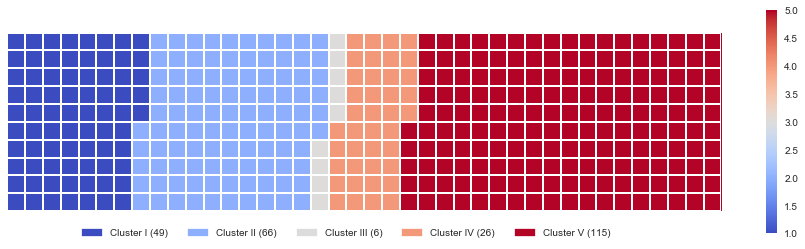

In [183]:
index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V'] # excluding cluster V since it has 0 values
portions = [cl1.shape[0], cl2.shape[0], cl3.shape[0], cl4.shape[0],cl5.shape[0]]
width = 40 # width of chart
height = 10 # height of chart

categories = index # categories
values = portions # correponding values of categories

colormap = plt.cm.coolwarm# color map class
create_waffle_chart(categories, values, height, width, colormap)

Bar Charts

In [195]:
tmp = np.zeros((kmeans.cluster_centers_.shape))
tmp[0,:] = kmeans.cluster_centers_[0,:]
tmp[1,:] = kmeans.cluster_centers_[1,:]
tmp[2,:] = kmeans.cluster_centers_[2,:]
tmp[3,:] = kmeans.cluster_centers_[3,:]
tmp[4,:] = kmeans.cluster_centers_[4,:]
maxi = []
for i in range(5):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 
                                                              'Cluster IV','Cluster V'],
                                                              columns = giri_grouped.columns[args.astype(int)])
table = table.transpose()

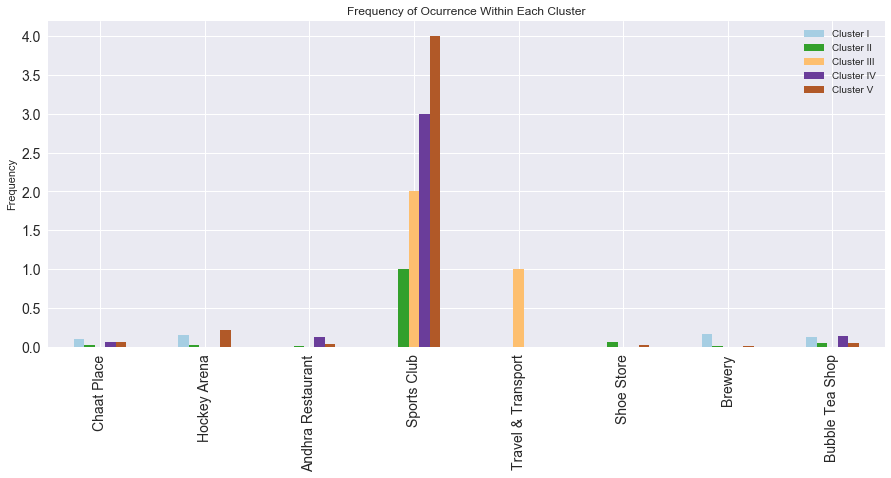

In [196]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()

In [197]:
maxi = []
for i in range(4):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 
                                                              'Cluster IV','Cluster V'],
                                                              columns = giri_grouped.columns[args.astype(int)])
table = table.T
table.drop(["Sports Club"], inplace= True)

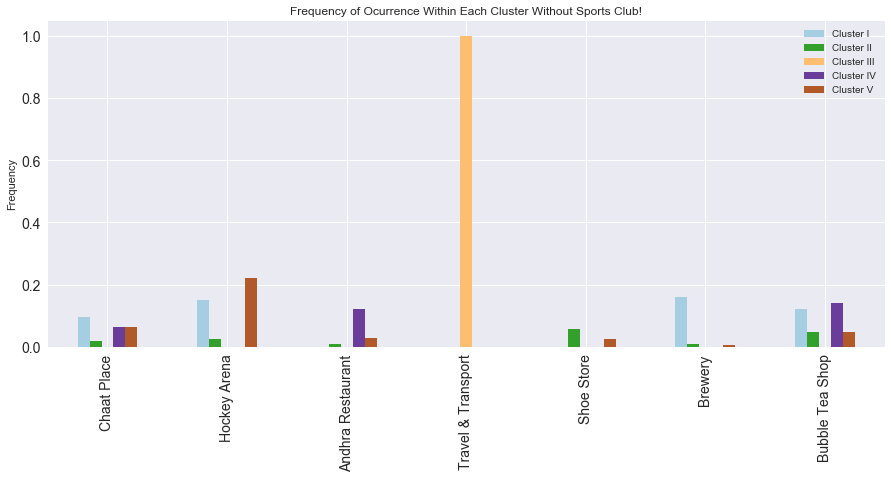

In [198]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = "Paired")
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster Without Sports Club!")
plt.ylabel("Frequency")
plt.show()

Conclusion:
Both cities are dotted with amenities necessary for modern lifestyle. Neighborhoods falling in cluster 5 in both cities offer largest number of amenities. A person can choose neighborhoods based on paygrade, rentals withn cluster 5.